In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import COASTLINE
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from scipy.stats import binned_statistic_2d

from mpl_toolkits.basemap import Basemap
from cartopy.feature import LAND, OCEAN, COASTLINE  # Import the LAND, OCEAN and COASTLINE features
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter 
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator
from matplotlib.path import Path
import os

def set_color_definitions(cri):
    global colors, intensity_labels, boundary_norm
    if cri == 0 or cri == 1:
        colors = ["cornflowerblue", "forestgreen", "orange", "magenta", "red"]
        intensity_labels = ["TS", "STS", "TY", "STY", "SSTY"]
        boundary_norm = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
        ncol = 5
        
    elif cri == 2:
        colors = ["cornflowerblue", "forestgreen", "orange", "magenta", "red", "purple"]
        intensity_labels = ["TS", "CAT1", "CAT2", "CAT3", "CAT4", "CAT5"]
        boundary_norm = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
        ncol = 6


def plot_storm_tracks(storm_data, ax, mstep, cri):

    # Call set_color_definitions to set the color definitions
    set_color_definitions(cri)

    # Create a list to store storm data temporarily
    storm_data_temp = []

    for storm_id, storm_d in storm_data.groupby('SID'):
        if len(storm_d) >= mstep:
            max_uni_cat = storm_d['UNI_CAT'].max()
            storm_data_temp.append((storm_d, max_uni_cat))

    # Sort the storm data by the maximum 'UNI_CAT' value in ascending order
    storm_data_temp.sort(key=lambda x: x[1])

    scount = 0
    min_len = 4  # just for drawing
    
    for storm_d, max_uni_cat in storm_data_temp:
        check = 0
        scount += 1
        x = np.array(storm_d['LON'])
        y = np.array(storm_d['LAT'])
        CAT = np.array(storm_d['UNI_CAT'])
        tmp_x, tmp_y, tmp_CAT = [], [], []

        for i in range(len(x)-1):
            if abs(x[i+1]-x[i]) < 120:
                tmp_x.append(x[i])
                tmp_y.append(y[i])
                tmp_CAT.append(CAT[i])

            else:              
                if len(tmp_x)>min_len: # min_len = 10 was used in early days
                    xx = savitzky_golay(tmp_x, 11, 3)
                    yy = savitzky_golay(tmp_y, 11, 3)
                    dydx = tmp_CAT

                    points = np.array([xx, yy]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)

                    cmap = ListedColormap(colors)
                    norm = BoundaryNorm(boundary_norm, cmap.N)

                    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1)
                    lc.set_array(dydx)

                    ax.add_collection(lc)

                del tmp_x, tmp_y, tmp_CAT
                tmp_x = []
                tmp_y = []
                tmp_CAT = []
        if len(tmp_x)>min_len:
            xx = savitzky_golay(tmp_x, 11, 5)
            yy = savitzky_golay(tmp_y, 11, 5)
            dydx = tmp_CAT

            points = np.array([xx, yy]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            cmap = ListedColormap(colors)
            norm = BoundaryNorm(boundary_norm, cmap.N)

            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1)
            lc.set_array(dydx)

            ax.add_collection(lc)

    return scount

def setup_map_and_grid(ax, lon1, lon2, lat1, lat2):
    ax.add_feature(COASTLINE, edgecolor='black', zorder=10)
    ax.add_feature(LAND, facecolor="burlywood", alpha=0.9)     # Set the land color to a semi-transparent shade of brown
    ax.add_feature(OCEAN, facecolor="lightblue", alpha=0.9)
    ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.7, color='gray', alpha=0.5, linestyle='--', dms=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.bottom_labels = False

def create_custom_legend():
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=15, label=intensity_labels[i])
                       for i in range(len(colors))]
    return legend_elements

#########   self defined version of savitzky golay filter   ####################################
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

###############################################################################################

# Function to calculate frequency distribution
def calculate_frequency_distribution(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep):
    # Filter out short-lived storms
    sub_data = sub_data.groupby('SID').filter(lambda x: len(x) >= mstep)

    # Calculate the total number of years in the dataset
    total_years = sub_data['YEAR'].nunique()

    # Calculate the frequency map
    lon = sub_data['LON']
    lat = sub_data['LAT']
    bins_x = np.arange(lon_min, lon_max, grid_resolution)
    bins_y = np.arange(lat_min, lat_max, grid_resolution)
    frequency, _, _ = np.histogram2d(lon, lat, bins=[bins_x, bins_y])

    # Calculate the average frequency per year for each grid cell
    average_frequency = frequency / total_years

    # Replace NaN values with 0 to display them as white in plots
    average_frequency[np.isnan(average_frequency)] = 0

    return average_frequency

def calculate_genesis_frequency(storm_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep):
    
    # Calculate the total number of years in the dataset
    total_years = storm_data['YEAR'].nunique()    
    
    # Create a DataFrame to store storm data temporarily
    storm_data_temp = pd.DataFrame(columns=['LON', 'LAT'])

    scount = 0

    for storm_id, storm_d in storm_data.groupby('SID'):
        # Filter out short-lived storms
        if len(storm_d) >= mstep:
            # Take only the first point of each storm track
            genesis_point = storm_d.iloc[0]
            # Append the 'LON' and 'LAT' values to the temporary DataFrame
            storm_data_temp.loc[scount, 'LON'] = genesis_point['LON']
            storm_data_temp.loc[scount, 'LAT'] = genesis_point['LAT']
            scount += 1

    # Convert 'LON' and 'LAT' columns to numeric
    storm_data_temp['LON'] = pd.to_numeric(storm_data_temp['LON'])
    storm_data_temp['LAT'] = pd.to_numeric(storm_data_temp['LAT'])

    # Calculate the frequency map
    lon = storm_data_temp['LON']
    lat = storm_data_temp['LAT']
    bins_x = np.arange(lon_min, lon_max, grid_resolution)
    bins_y = np.arange(lat_min, lat_max, grid_resolution)
    frequency, _, _ = np.histogram2d(lon, lat, bins=[bins_x, bins_y])

    # Calculate the average frequency per year for each grid cell
    average_genesis_frequency = frequency / total_years

    # Replace NaN values with 0 to display them as white in plots
    average_genesis_frequency[np.isnan(average_genesis_frequency)] = 0

    return average_genesis_frequency


In [3]:
#####################################################################################################
# convert to (-180, 180) | year-range selection | domain selection ##################################
def trans_trim_dframe(df, lon_col='LON', lat_col='LAT', time_col='ISO_TIME', start_year=None, end_year=None, lon_min=None, lon_max=None, lat_min=None, lat_max=None):
    # Transform 'LON' values to (-180, 180) range
    df[lon_col] = df[lon_col].apply(lambda lon: lon if lon <= 180 else lon - 360)

    # Extract the years from the "ISO_TIME" column
    df['YEAR'] = pd.to_datetime(df[time_col]).dt.year

    # Filter data for the needed years
    if start_year is not None and end_year is not None:
        y_range = range(start_year, end_year + 1)
        df = df[df['YEAR'].isin(y_range)]

    # Filter data for the specified region
    if lon_min is not None and lon_max is not None and lat_min is not None and lat_max is not None:
        df = df[(df[lon_col] >= lon_min) & (df[lon_col] <= lon_max) &
                (df[lat_col] >= lat_min) & (df[lat_col] <= lat_max)]

    return df

###############################################################################################

def point_in_polygon(lon, lat, polygon_path):
    return polygon_path.contains_point((lon, lat))

def basin_data(in_df, basin=None):
    
    # Read the dataframe
    df = in_df
    
    # Convert longitude values from [0, 360) to [-180, 180)
    df['LON'] = (df['LON'] + 180) % 360 - 180

    # Check if basin is provided
    if basin is not None:
        # Define the polygon coordinates based on the provided basin
        
        if basin == 'Glb':
            polygon_coords = np.array([[-180, 50], [-180, -50], [180, -50], [180, 50], [-180, 50]])
            
        elif basin == 'NA':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [0, 50], [0, 0], [-70, 0]])
            
        elif basin == 'EP':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [-180, 50], [-180, 0], [-70, 0]])            
            
        elif basin == 'WNP': 
            polygon_coords = np.array([[100, 0], [100, 50], [180, 50], [180, 0], [100, 0]]) 
            
        elif basin == 'NI': 
            polygon_coords = np.array([[30, 0], [30, 50], [100, 50], [100, 0], [30, 0]]) 

        elif basin == 'SI': 
            polygon_coords = np.array([[10, 0], [10, -50], [135, -50], [135, 0], [10, 0]])            

        elif basin == 'SA': 
            polygon_coords = np.array([[10, 0], [10, -50], [-70, -50], [-70, 0], [10, 0]]) 

        elif basin == 'SP':  # this is special case. So, coordinate in 0 to 360 form
            polygon_coords = np.array([[135, 0], [135, -50], [290, -50], [290, 0], [135, 0]]) 

        # Create the polygon path
        polygon_path = Path(polygon_coords)

        # Filter rows based on the condition      
        if basin == 'SP':
            
            # Convert longitude values from [-180, 180] to [0, 360] before applying mask
            df['LON'] = (df['LON'] + 360) % 360 
            
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
    
            # Convert longitude values from back to [-180, 180]
            filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
            
        else:
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
            
        return filtered_df
    # If basin is not provided, return the original DataFrame
    return df

#######################################################################################################

# Function to calculate bias
def calculate_bias(obs_frequency, exp_frequency):
    return exp_frequency - obs_frequency

# Function to calculate mean bias
def calculate_mean_bias(bias):
    return np.mean(bias)

# Function to calculate RMSE
def calculate_rmse(bias):
    return np.sqrt(np.mean(bias**2))

# Function to calculate MAE
def calculate_mae(bias):
    return np.mean(np.abs(bias))


In [4]:
# Load the datasets
sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')
sub_data_2 = pd.read_csv('../Data/f3L_w15.2_Walsh.csv')
sub_data_3 = pd.read_csv('../Data/f3H_w17.1_Walsh.csv')
sub_data_4 = pd.read_csv('../Data/f3HH_w17.4_Walsh.csv')

exp_name_1 = 'IBTrACS'
exp_name_2 = 'f3-L'
exp_name_3 = 'f3-H'
exp_name_4 = 'f3-HH'

start_year = 1998
end_year = 2007

# Define the domain (this is for global TC region)
lon_min, lon_max = -180, 180
lat_min, lat_max = -50, 50

# Define the step threshold for dropping out short-lived systems
mstep_ob = 4
mstep_mo = 12
cri = 2   # 0-Liu, 1-CMA, 2-SS
cls ='SS'

# Define the grid resolution for track density
grid_resolution = 2      # 1,2,5 degree typically
common_max_fvalue = 5.6   # 2.4, 5.6, 24   This is for color scale, this value based on your data

# To filter data for the needed years
y_range = range(start_year, end_year+1)


# Ready to go ....

sub_data_1 = trans_trim_dframe(sub_data_1, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_2 = trans_trim_dframe(sub_data_2, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_3 = trans_trim_dframe(sub_data_3, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)
sub_data_4 = trans_trim_dframe(sub_data_4, start_year=start_year, end_year=end_year, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max)

/tmp/ipykernel_1921/4270787466.py:2: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')


Figure saved as: ../Figure/06_Global TC Track & Genesis Frequency Biases.pdf


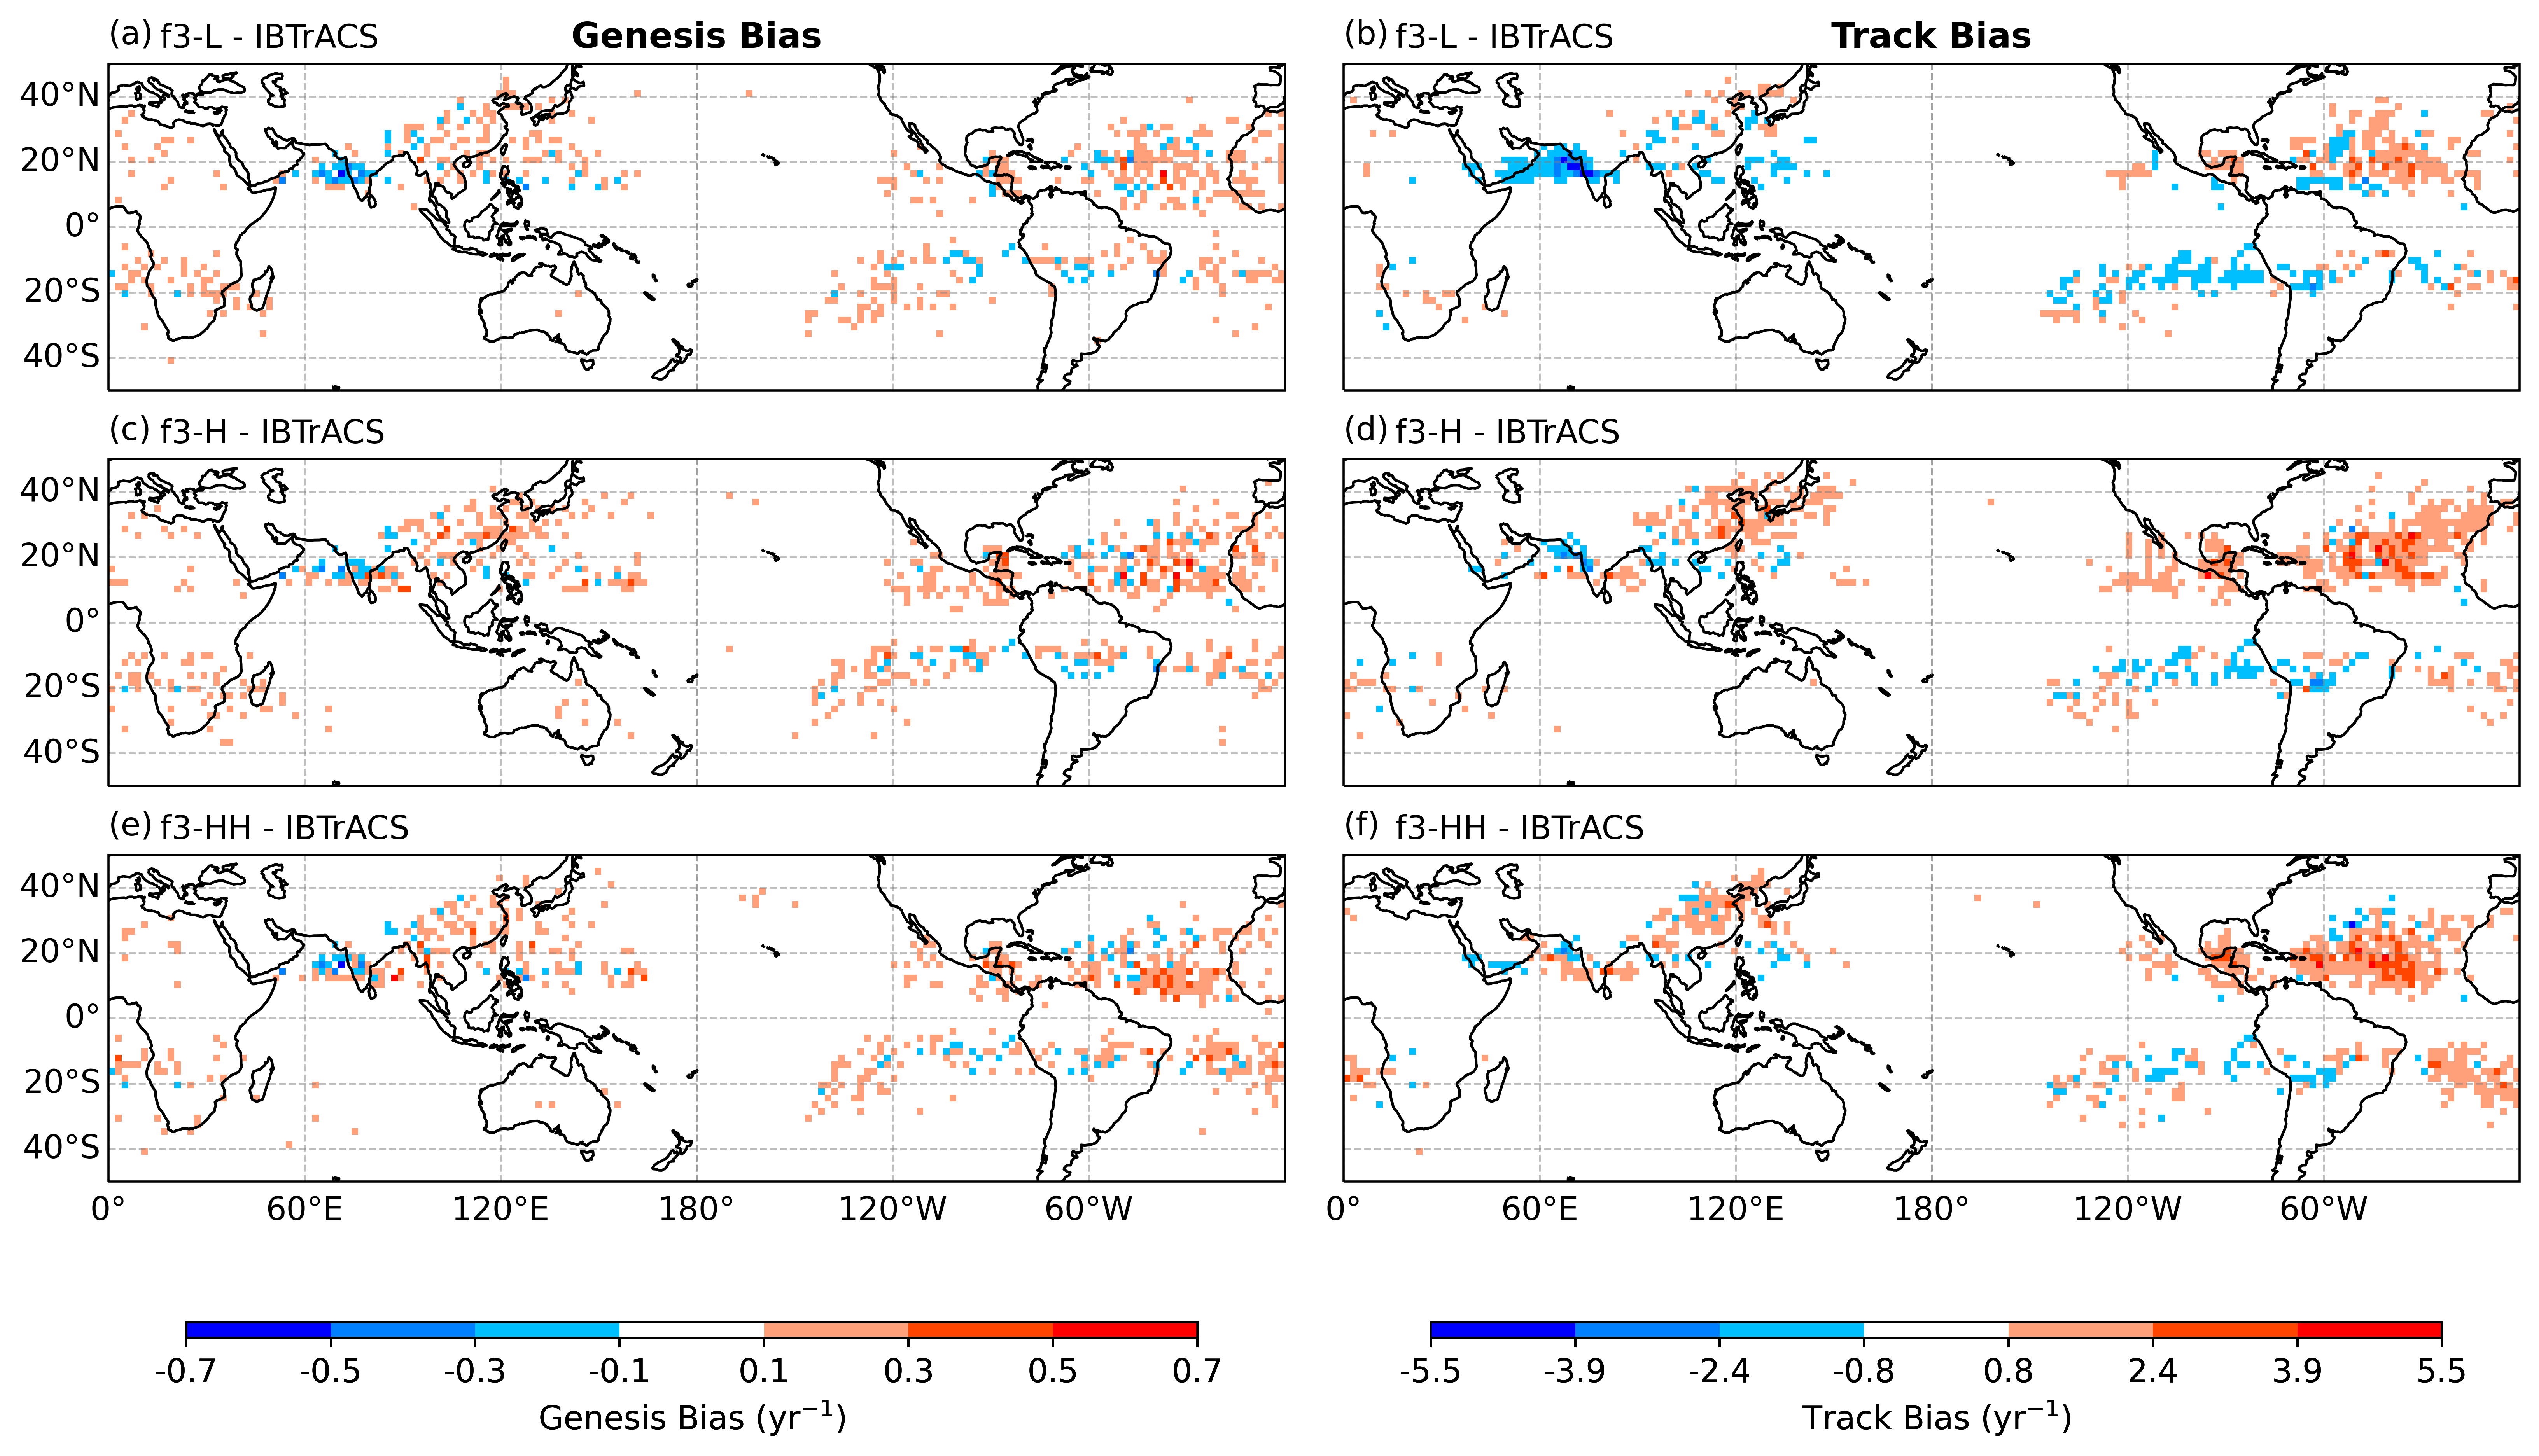

In [5]:
# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) # this is only for background map
fig.set_dpi(500)

lon1, lon2, lat1, lat2 = -180, 180, -50, 50  # Mapping area

# Calculate genesis and track frequencies for observation
obs_genesis_frequency = calculate_genesis_frequency(sub_data_1, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep_ob)
obs_track_frequency = calculate_frequency_distribution(sub_data_1, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep_ob)

# Initialize lists to store biases
genesis_biases = []
track_biases = []

# Plot the biases for each experiment
for i, (ax1, ax2, sub_data, exp_name) in enumerate(zip(axs[:,0], axs[:,1], [sub_data_2, sub_data_3, sub_data_4], [exp_name_2, exp_name_3, exp_name_4])):

    if exp_name == exp_name_1:    
        mstep = mstep_ob
    else:
        mstep = mstep_mo    
    
    # Calculate genesis and track frequencies for the experiment
    exp_genesis_frequency = calculate_genesis_frequency(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep)
    exp_track_frequency = calculate_frequency_distribution(sub_data, grid_resolution, lon_min, lon_max, lat_min, lat_max, mstep)
    
    # Calculate the biases
    genesis_bias = calculate_bias(obs_genesis_frequency, exp_genesis_frequency)
    track_bias = calculate_bias(obs_track_frequency, exp_track_frequency)
    
    # Store the biases
    genesis_biases.append(genesis_bias)
    track_biases.append(track_bias)

# Determine the overall minimum and maximum values for genesis and track biases
genesis_min = np.min([np.min(bias) for bias in genesis_biases])
genesis_max = np.max([np.max(bias) for bias in genesis_biases])
track_min = np.min([np.min(bias) for bias in track_biases])
track_max = np.max([np.max(bias) for bias in track_biases])

# Calculate symmetric range
genesis_range = max(abs(genesis_min), abs(genesis_max))
track_range = max(abs(track_min), abs(track_max))

# Define custom color segments with plain white near zero
colors = ['#0000FF', '#007FFF', '#00BFFF', '#ffffff', '#FFA07A', '#FF4500', '#FF0000']
cmap = ListedColormap(colors)

# Define symmetric boundaries for the color segments
genesis_boundaries = np.linspace(-genesis_range, genesis_range, len(colors) + 1)
track_boundaries = np.linspace(-track_range, track_range, len(colors) + 1)

# Define the common color bar for genesis and track biases
norm_genesis = BoundaryNorm(genesis_boundaries, cmap.N)
norm_track = BoundaryNorm(track_boundaries, cmap.N)

# Plot the biases using the common color bar
for i, (ax1, ax2, genesis_bias, track_bias, exp_name) in enumerate(zip(axs[:,0], axs[:,1], genesis_biases, track_biases, [exp_name_2, exp_name_3, exp_name_4])):

    # Plot the genesis frequency bias
    im1 = ax1.imshow(genesis_bias.T, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cmap, norm=norm_genesis, origin='lower')
    ax1.set_title(f'     {exp_name} - {exp_name_1}', loc='left')
    setup_map_and_grid(ax1, lon1, lon2, lat1, lat2)

    # Plot the track frequency bias
    im2 = ax2.imshow(track_bias.T, extent=[lon_min, lon_max, lat_min, lat_max], cmap=cmap, norm=norm_track, origin='lower')
    ax2.set_title(f'     {exp_name} - {exp_name_1}', loc='left')
    setup_map_and_grid(ax2, lon1, lon2, lat1, lat2)

    # Add colorbars for genesis bias
    cax1 = fig.add_axes([0.15, 0.02, 0.325, 0.01])  #[x, y, width, height] Adjust the position and size as needed
    cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal', format=FormatStrFormatter('%.1f'))
    cbar1.ax.tick_params(labelsize=12)  # Set the font size for the color bar tick labels
    cbar1.set_label('Genesis Bias (yr$^{-1}$)', fontsize=12)

    # Add colorbars for track bias
    cax2 = fig.add_axes([0.55, 0.02, 0.325, 0.01])  #[x, y, width, height] Adjust the position and size as needed
    cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal', format=FormatStrFormatter('%.1f'))
    cbar2.ax.tick_params(labelsize=12)  # Set the font size for the color bar tick labels    
    cbar2.set_label('Track Bias (yr$^{-1}$)', fontsize=12)

#############################################################################################################################    
    
ax_px=0.0
ax_py=1.06 # 0.99

# Add labeling in the first row
for i, label in enumerate(['a', 'b']):
    axs[0][i].text(ax_px, ax_py, f'({label})', transform=axs[0][i].transAxes, fontsize=12) # weight='bold'
    
# Add labeling in the second row
for i, label in enumerate(['c', 'd']):
    axs[1][i].text(ax_px, ax_py, f'({label})', transform=axs[1][i].transAxes, fontsize=12) # weight='bold'

# Add labeling
for i, label in enumerate(['e', 'f']):
    axs[2][i].text(ax_px, ax_py, f'({label})', transform=axs[2][i].transAxes, fontsize=12) # weight='bold'
    gl = axs[2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.01, linestyle='--', dms=True)
    gl.xlabel_style = {'size': 12, 'color': 'black'}  # Set font size and color for x-axis labels
    gl.ylabel_style = {'size': 12, 'color': 'black'}  # Set font size and color for y-axis labels
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False

# Add labeling
for i, label in enumerate(['a', 'c', 'e']):
    gl = axs[i][0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.01, linestyle='--', dms=True)
    gl.ylabel_style = {'size': 12, 'color': 'black'}  # Set font size and color for y-axis labels
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    
axs[0][0].set_title(f'Genesis Bias', loc='center', fontsize=13, weight='bold')   
axs[0][1].set_title(f'Track Bias', loc='center', fontsize=13, weight='bold')   

# Set a meaningful title for the entire figure
# fig.suptitle(f'Tropical Cyclone Bias Distribution over the Globe ({start_year}-{end_year}) Cri: SS', fontsize=16, y=0.93)
# Adjust the gap between subplots and figure title

fig.subplots_adjust(top=0.85, hspace=0.1, wspace=0.05)
# plt.tight_layout()

# Save the figure
os.makedirs('../Figure', exist_ok=True)
save_path = '../Figure/06_Global TC Track & Genesis Frequency Biases.pdf'
plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
print(f"Figure saved as: {save_path}")    

plt.show()

Exp.	Mean Bias (Genesis)	RMSE (Genesis)	MAE (Genesis)	Mean Bias (Track)	RMSE (Track)	MAE (Track)
f3-L	0.000		0.047		0.013		0.015		0.405		0.162
f3-H	0.003		0.049		0.014		0.106		0.464		0.196
f3-HH	0.003		0.049		0.014		0.110		0.474		0.192


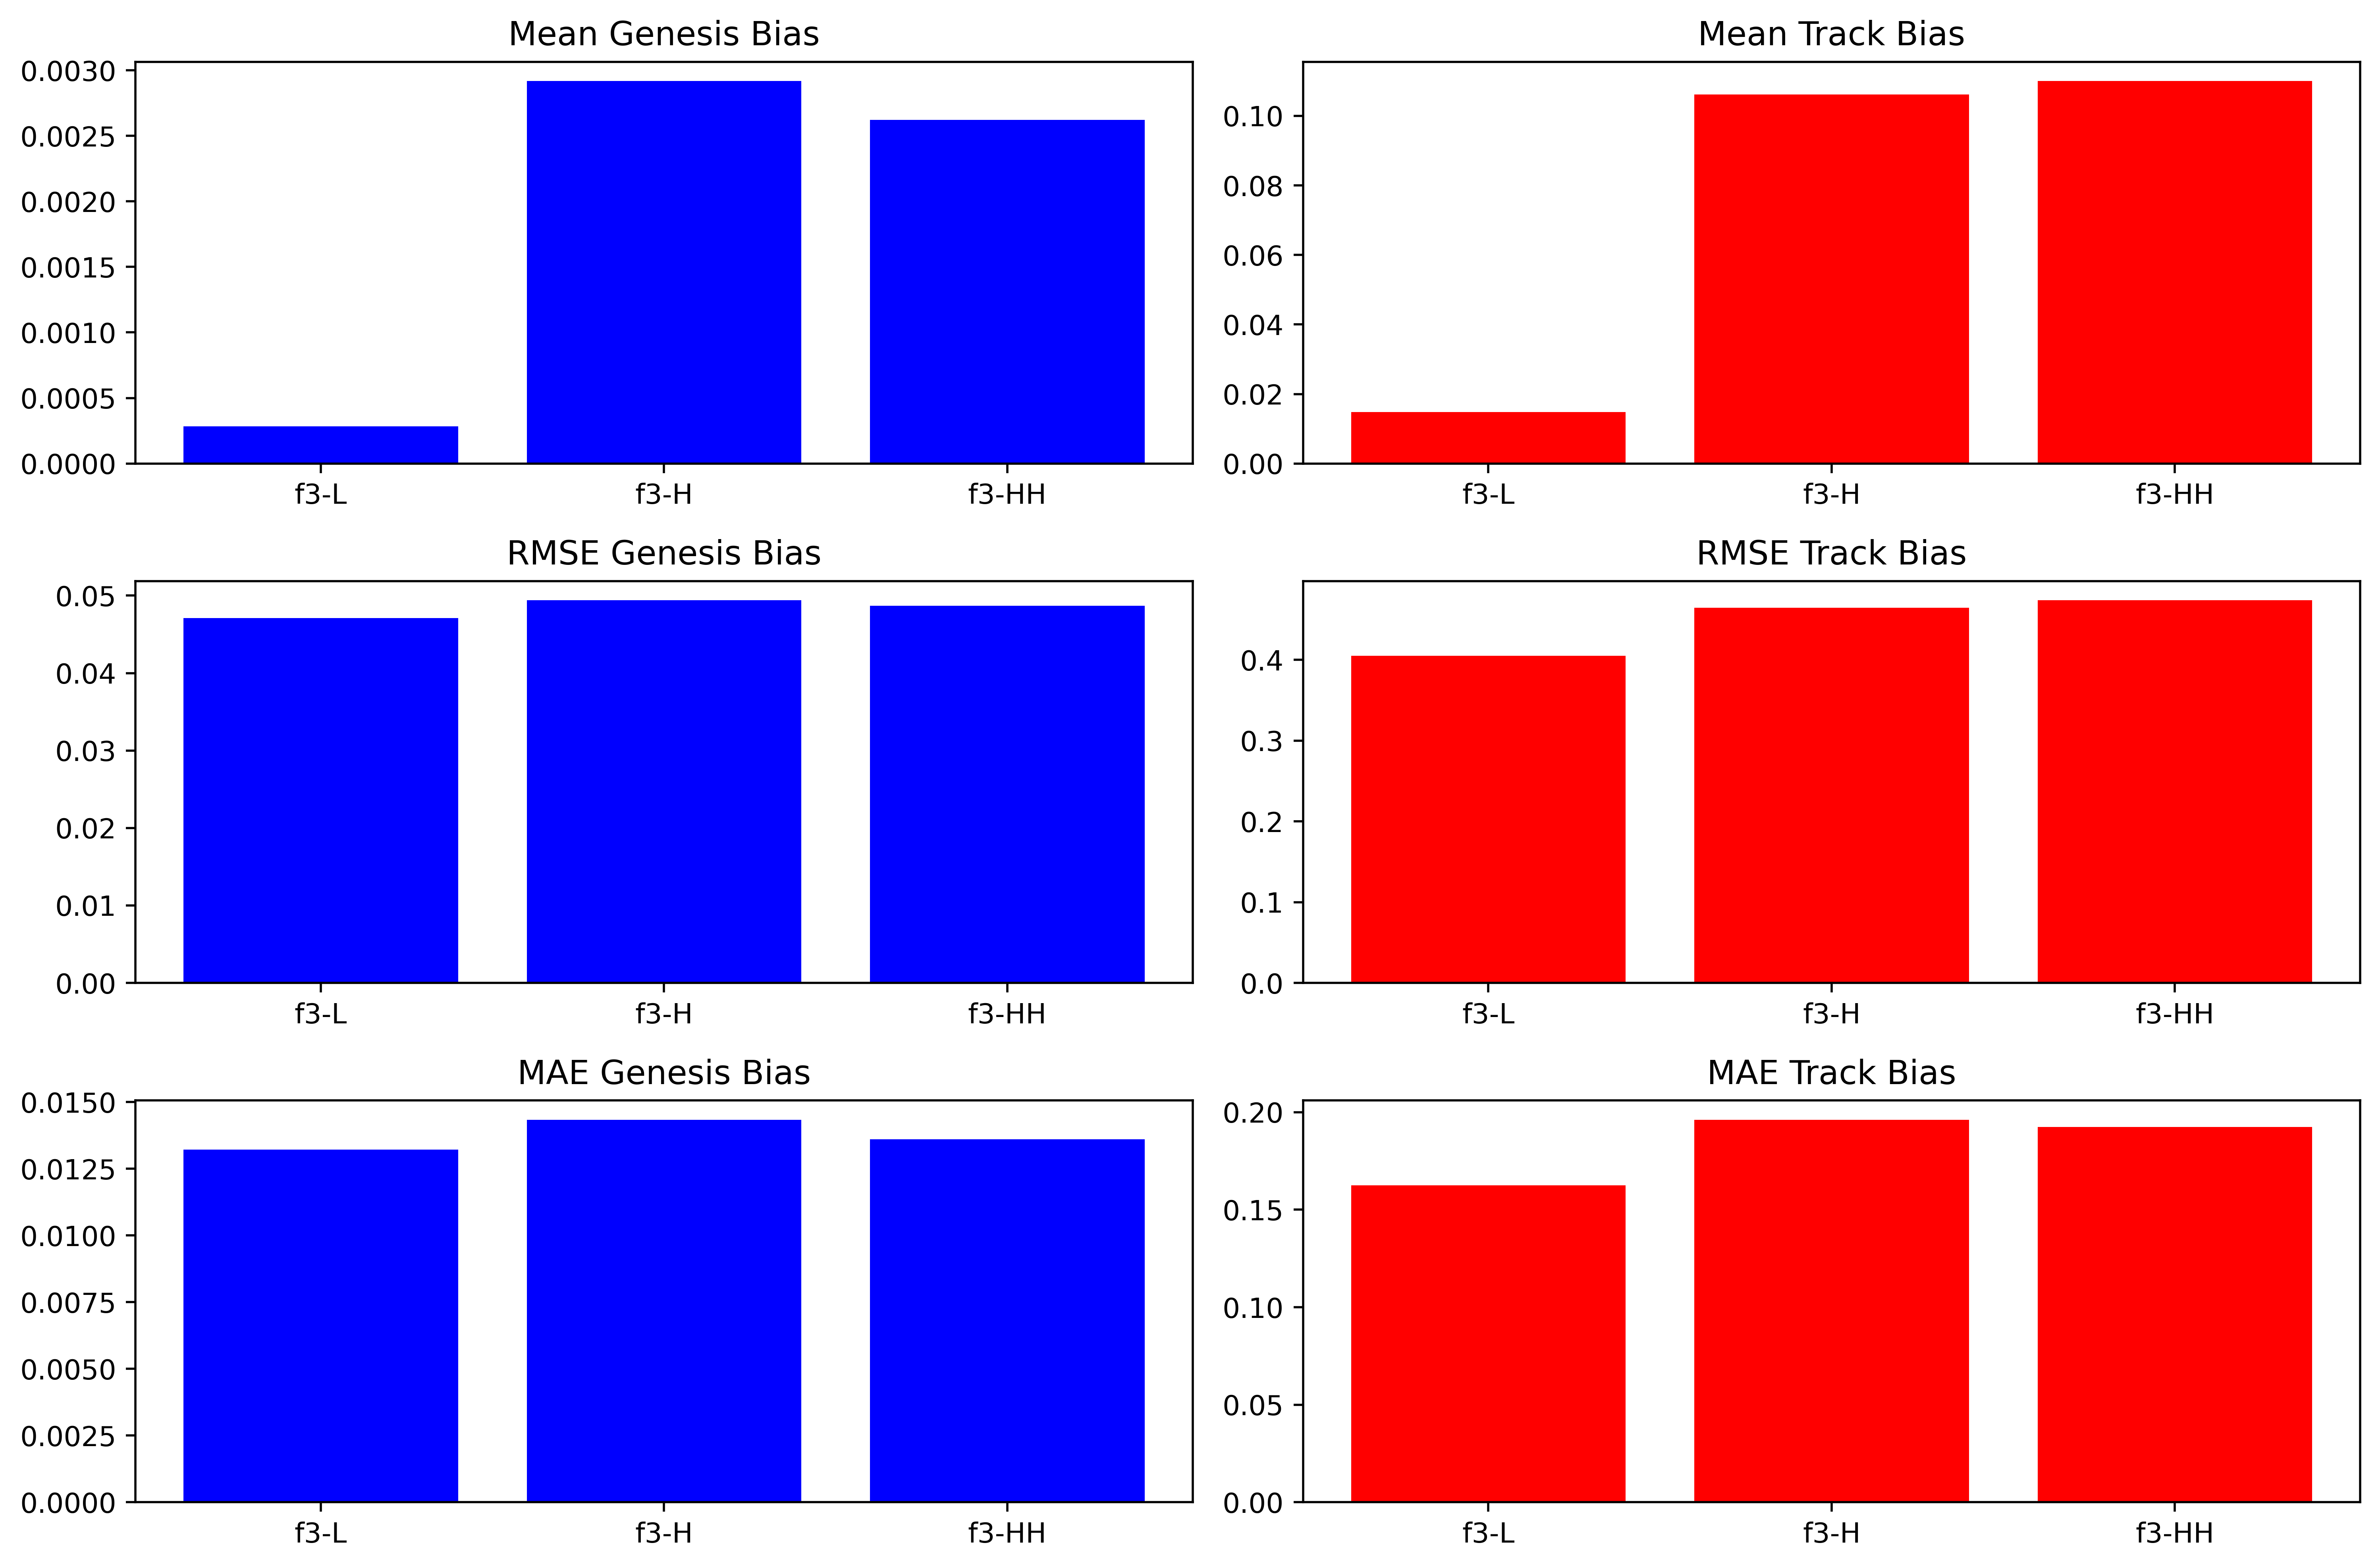

In [6]:
# Calculate and print the mean bias, RMSE, and MAE for each experiment
mean_biases_genesis = [calculate_mean_bias(bias) for bias in genesis_biases]
rmse_genesis = [calculate_rmse(bias) for bias in genesis_biases]
mae_genesis = [calculate_mae(bias) for bias in genesis_biases]

mean_biases_track = [calculate_mean_bias(bias) for bias in track_biases]
rmse_track = [calculate_rmse(bias) for bias in track_biases]
mae_track = [calculate_mae(bias) for bias in track_biases]

# Print the statistics
print("Exp.\tMean Bias (Genesis)\tRMSE (Genesis)\tMAE (Genesis)\tMean Bias (Track)\tRMSE (Track)\tMAE (Track)")
for i, exp_name in enumerate([exp_name_2, exp_name_3, exp_name_4]):
    print(f"{exp_name}\t{mean_biases_genesis[i]:.3f}\t\t{rmse_genesis[i]:.3f}\t\t{mae_genesis[i]:.3f}\t\t{mean_biases_track[i]:.3f}\t\t{rmse_track[i]:.3f}\t\t{mae_track[i]:.3f}")

# Display the statistics in a table
stats_df = pd.DataFrame({
    'Experiment': [exp_name_2, exp_name_3, exp_name_4],
    'Mean Bias (Genesis)': mean_biases_genesis,
    'RMSE (Genesis)': rmse_genesis,
    'MAE (Genesis)': mae_genesis,
    'Mean Bias (Track)': mean_biases_track,
    'RMSE (Track)': rmse_track,
    'MAE (Track)': mae_track
})

# print(stats_df)

# Plot the statistics in bar graphs
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.set_dpi(500)

# Plot mean bias
axs[0, 0].bar([exp_name_2, exp_name_3, exp_name_4], mean_biases_genesis, color='blue')
axs[0, 0].set_title('Mean Genesis Bias')
axs[0, 1].bar([exp_name_2, exp_name_3, exp_name_4], mean_biases_track, color='red')
axs[0, 1].set_title('Mean Track Bias')

# Plot RMSE
axs[1, 0].bar([exp_name_2, exp_name_3, exp_name_4], rmse_genesis, color='blue')
axs[1, 0].set_title('RMSE Genesis Bias')
axs[1, 1].bar([exp_name_2, exp_name_3, exp_name_4], rmse_track, color='red')
axs[1, 1].set_title('RMSE Track Bias')

# Plot MAE
axs[2, 0].bar([exp_name_2, exp_name_3, exp_name_4], mae_genesis, color='blue')
axs[2, 0].set_title('MAE Genesis Bias')
axs[2, 1].bar([exp_name_2, exp_name_3, exp_name_4], mae_track, color='red')
axs[2, 1].set_title('MAE Track Bias')

plt.tight_layout()
